# **Anomaly Detection using Auto Encoders**

### Objective

The objective of using the autoencoder for anomaly detection is to identify atypical bike rides by learning the normal patterns in the data and flagging outlier rides based on high reconstruction error, which could indicate data errors, sensor malfunctions, or unusual user behavior.

Detect anomalies in bike ride data by learning normal riding patterns using an autoencoder. Identify unusual rides (for example, zero distance over long durations) that may indicate data errors, sensor issues, or atypical user behavior.

In [ ]:
%pip install tensorflow keras-tuner

In [6]:
# Set TensorFlow configuration first, before importing TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TF logging
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU usage
os.environ["TF_NUM_INTEROP_THREADS"] = "4"  # Set inter-op parallelism
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"  # Set intra-op parallelism

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from joblib import Parallel, delayed
from tensorflow.keras import layers
from keras_tuner import Hyperband, RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split


In [7]:
# Enable Multi-threading for NumPy
os.environ["OMP_NUM_THREADS"] = "8"

In [8]:
# Verify TensorFlow is using CPU
print("TensorFlow devices:", tf.config.list_physical_devices())
print("TensorFlow version:", tf.__version__)

TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.18.0


## Data Loading, Cleaning and Preprocessing

1. Loading data into data frame from combined_tripdata.csv data source which has been downloaded from https://divvy-tripdata.s3.amazonaws.com/
1. Validating non standard datatypes in started_at column
1. Identifying problematic rows if started_at column has invalid dates
1. Converting timestamps in started_at, ended_at columns while handling extra milliseconds
1. Dropping invalid data points if started_at, ended_at has NA values
1. Dropping rows where ended_at is earlier than 'started_at' (data inconsistencies)
1. Calculating ride_distance_km colum using geo coordinates using haversine calculation formula based on radius of earth.

In [9]:
DATA_PATH = '../../data/combined_tripdata.csv'
data = pd.read_csv(DATA_PATH)
print(data.head())

C:\Users\Swapnil.Patil\AppData\Local\Temp\ipykernel_32896\1721040238.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_PATH)


            ride_id rideable_type           started_at             ended_at  \
0  A847FADBBC638E45   docked_bike  2020-04-26 17:45:14  2020-04-26 18:12:03   
1  5405B80E996FF60D   docked_bike  2020-04-17 17:08:54  2020-04-17 17:17:03   
2  5DD24A79A4E006F4   docked_bike  2020-04-01 17:54:13  2020-04-01 18:08:36   
3  2A59BBDF5CDBA725   docked_bike  2020-04-07 12:50:19  2020-04-07 13:02:31   
4  27AD306C119C6158   docked_bike  2020-04-18 10:22:59  2020-04-18 11:15:54   

             start_station_name start_station_id             end_station_name  \
0                  Eckhart Park             86.0  Lincoln Ave & Diversey Pkwy   
1     Drake Ave & Fullerton Ave            503.0              Kosciuszko Park   
2          McClurg Ct & Erie St            142.0   Indiana Ave & Roosevelt Rd   
3  California Ave & Division St            216.0       Wood St & Augusta Blvd   
4          Rush St & Hubbard St            125.0   Sheridan Rd & Lawrence Ave   

  end_station_id  start_lat  start_lng

In [10]:
# Check for non-standard datetime formats in the 'started_at' column
data['started_at'] = data['started_at'].astype(str)  # Ensure it's a string for processing
data['ended_at'] = data['ended_at'].astype(str)

In [11]:
# Identify problematic rows
invalid_start_times = data[~data['started_at'].str.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}(\.\d+)?', na=False)]
invalid_end_times = data[~data['ended_at'].str.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}(\.\d+)?', na=False)]
# Display problematic rows
invalid_start_times.head(), invalid_end_times.head()

(Empty DataFrame
 Columns: [ride_id, rideable_type, started_at, ended_at, start_station_name, start_station_id, end_station_name, end_station_id, start_lat, start_lng, end_lat, end_lng, member_casual]
 Index: [],
 Empty DataFrame
 Columns: [ride_id, rideable_type, started_at, ended_at, start_station_name, start_station_id, end_station_name, end_station_id, start_lat, start_lng, end_lat, end_lng, member_casual]
 Index: [])

In [12]:
# Convert timestamps while handling extra milliseconds
data['started_at'] = pd.to_datetime(data['started_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
data['ended_at'] = pd.to_datetime(data['ended_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [13]:
# Drop rows with invalid datetime conversion (NaT values)
data = data.dropna(subset=['started_at', 'ended_at'])

# Verify the conversion
data[['started_at', 'ended_at']].head()

,started_at,ended_at
0,2020-04-26 17:45:14,2020-04-26 18:12:03
1,2020-04-17 17:08:54,2020-04-17 17:17:03
2,2020-04-01 17:54:13,2020-04-01 18:08:36
3,2020-04-07 12:50:19,2020-04-07 13:02:31
4,2020-04-18 10:22:59,2020-04-18 11:15:54


In [14]:
# Remove rows where 'ended_at' is earlier than 'started_at' (data inconsistencies)
data = data[data['ended_at'] >= data['started_at']]

Engineering features...

Feature Statistics:
       ride_duration  ride_distance_km     speed_kmh    start_hour  \
count   2.107911e+07      2.105571e+07  2.105301e+07  2.107911e+07   
mean    2.094514e+01      2.151812e+00  1.057088e+01  1.419234e+01   
std     1.867822e+02      7.358869e+00  5.668216e+02  4.929343e+00   
min     0.000000e+00      0.000000e+00  0.000000e+00  0.000000e+00   
25%     6.116667e+00      8.694142e-01  6.937716e+00  1.100000e+01   
50%     1.095000e+01      1.596269e+00  1.037799e+01  1.500000e+01   
75%     2.003333e+01      2.837387e+00  1.344585e+01  1.800000e+01   
max     9.848907e+04      9.815429e+03  2.355100e+06  2.300000e+01   

       start_dayofweek  distance_duration_ratio  
count     2.107911e+07             2.105301e+07  
mean      3.102428e+00             1.761813e-01  
std       1.979557e+00             9.447026e+00  
min       0.000000e+00             0.000000e+00  
25%       1.000000e+00             1.156286e-01  
50%       3.000000e+00  

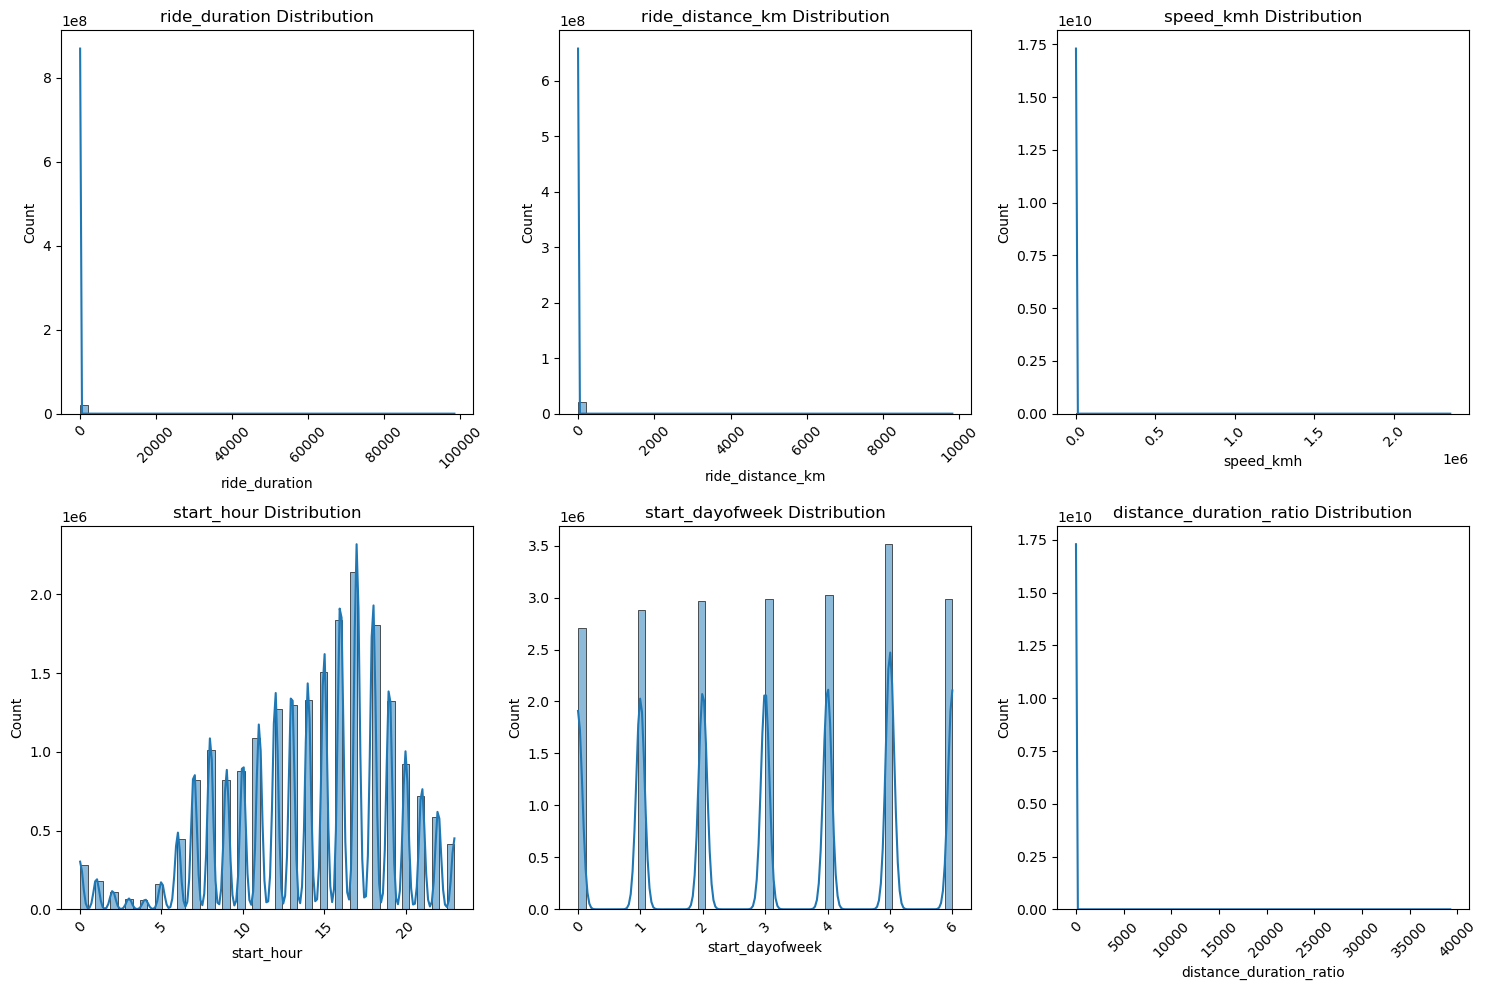

In [16]:
# Compute ride duration in minutes
# Compute ride distance using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Parallelize the haversine function
# data['ride_distance_km'] = Parallel(n_jobs=-1)(
#     delayed(haversine)(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']) 
#     for _, row in data.iterrows()
# )

# Feature engineering
print("Engineering features...")
data['ride_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60
data['ride_distance_km'] = data.apply(
    lambda row: haversine(row['start_lat'], row['start_lng'], 
                        row['end_lat'], row['end_lng']), axis=1)
data['speed_kmh'] = (data['ride_distance_km'] / (data['ride_duration']/60)).replace([np.inf, -np.inf], np.nan)
data['start_hour'] = data['started_at'].dt.hour
data['start_dayofweek'] = data['started_at'].dt.dayofweek
data['distance_duration_ratio'] = (data['ride_distance_km'] / data['ride_duration']).replace([np.inf, -np.inf], np.nan)

# Define features for anomaly detection
features = ['ride_duration', 'ride_distance_km', 'speed_kmh', 'start_hour', 
           'start_dayofweek', 'distance_duration_ratio']

# Display basic statistics
print("\nFeature Statistics:")
print(data[features].describe())

# Visualize feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[feature].dropna(), bins=50, kde=True)
    plt.title(f'{feature} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Interpretation:
1. **ride_duration** and **ride_distance_km** both have a huge majority of trips in relatively low ranges, but a small number of rides that last tens of thousands of seconds and/or cover thousands of kilometers. This suggests either a few genuinely long trips or possibly erroneous values.

1. **speed_kmh** (kilometers per hour) similarly has a dense concentration of normal‐looking speeds but a tiny fraction of rides with extremely large speed estimates, which again might be data errors or extreme edge cases.

1. **start_hour** shows that rides begin at all hours of the day, but in general peak during later afternoon to evening. This aligns with typical commuter or leisure ride behavior.

1. **start_dayofweek** has a repeated pattern for each day (0 through 6), with each day showing a distinct peak. Overall, usage is fairly consistent day to day, though some days appear to have slightly higher volumes.

1. **distance_duration_ratio** also exhibits extreme right‐skew, indicating that most trips have a modest ratio of distance to duration but a handful look unreasonably high—again likely outliers or data‐quality issues.

## Anomaly Detection using Auto Encoders

An autoencoder is a type of neural network designed to learn a compressed representation of data (the encoding) and then reconstruct the original input from that encoding (the decoding). Typically, it comprises two parts: an encoder and a decoder, with a bottleneck (latent space) in between (Goodfellow et al., 2016). By training the network to minimize the difference between the original and reconstructed inputs, the model learns to capture the core structure of the data.

Anomalies (or outliers) are data points that deviate significantly from the general pattern. Autoencoders, once trained on mostly normal data, reconstruct typical patterns well but produce high reconstruction errors for unusual or anomalous inputs (Sakurada & Yairi, 2014).

1. Unsupervised Learning: Autoencoders learn from unlabeled data, making them well-suited for scenarios where labeled anomalies are rare or unavailable (Chandola et al., 2009).

1. Reconstruction Error: After training, the reconstruction error ∥x− x^∥ serves as an anomaly score. Points with unusually high errors are flagged as anomalies (Aggarwal, 2017).

1. Capturing Complex Patterns: Deep autoencoders can model nonlinear relationships, handling high-dimensional data such as images, sensor readings, or time series more flexibly than simpler linear methods (Hinton & Salakhutdinov, 2006).

In [17]:
# Prepare data for the autoencoder
print("\nPreparing data for autoencoder...")
data_subset = data[features].copy()
data_subset = data_subset.replace([np.inf, -np.inf], np.nan)
data_subset = data_subset.dropna()

# Scale the features
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data_subset)

# Split the data
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)



Preparing data for autoencoder...
Training set shape: (16842411, 6)
Testing set shape: (4210603, 6)


The code implements a neural network called an autoencoder that:
1. Takes input data and compresses it through multiple layers:
input_dim -> 64 -> 32 -> 8 (encoded)
1. Reconstructs the data back through symmetric layers:
8 (encoded) -> 32 -> 64 -> input_dim
1. Uses key features:
    - ReLU activation for hidden layers
    - Batch normalization for stability
    - 20% dropout to prevent overfitting
    - MSE loss function for training

The autoencoder's main purpose is to learn a compressed representation of the input data while maintaining the ability to reconstruct it accurately. This is useful for anomaly detection and dimensionality reduction.

In [18]:
# Create the autoencoder model
def create_autoencoder(input_dim, encoding_dim=8):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    
    # Encoder layers with larger architecture
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    encoded = Dense(32, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder layers
    decoded = Dense(32, activation='relu')(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    
    decoded = Dense(64, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Create and compile model
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', 
                       loss='mse',
                       metrics=['mae'])
    
    return autoencoder

1. Model Creation:
    - Creates an autoencoder model with create_autoencoder()
    - Displays model architecture with model.summary()
1. Callbacks Setup:
    - EarlyStopping: Stops training if validation loss doesn't improve for 10 epochs, restores best weights.
    - ReduceLROnPlateau: Reduces learning rate by half if validation loss plateaus for 5 epochs, with a minimum learning rate of 1e-6.
1. Model Training:
    - Trains the model with model.fit()
    - Uses X_train for both input and target
    - Runs for 10 epochs with a batch size of 256
    - Validates with X_test
    - Includes early_stopping and reduce_lr callbacks
1. Training Visualization:
    - Plots training and validation loss over epochs using matplotlib
1. Callbacks:
    - EarlyStopping:
        - Monitors val_loss
        - Stops training if no improvement for 10 epochs
        - Restores best weights
    - ReduceLROnPlateau:
        - Monitors val_loss
        - Reduces learning rate by 50% if no improvement for 5 epochs
        - Minimum learning rate set to 1e-6



Creating and training the model...

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,350 (24.80 KB)

 Trainable params: 5,966 (23.30 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 145s 2ms/step - loss: 1017.7200 - mae: 0.7361 - val_loss: 82.5872 - val_mae: 0.3775 - learning_rate: 0.0010
Epoch 2/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 143s 2ms/step - loss: 3659.9043 - mae: 0.8652 - val_loss: 54.8221 - val_mae: 0.3870 - learning_rate: 0.0010
Epoch 3/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 145s 2ms/step - loss: 803.3703 - mae: 0.8307 - val_loss: 24.4859 - val_mae: 0.4102 - learning_rate: 0.0010
Epoch 4/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 152s 2ms/step - loss: 4185.8169 - mae: 0.8206 - val_loss: 15.8712 - val_mae: 0.3569 - learning_rate: 0.0010
Epoch 5/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 161s 2ms/step - loss: 1655.4369 - mae: 0.7678 - val_loss: 20.9171 - val_mae: 0.3161 - learning_rate: 0.0010
Epoch 6/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 185s 2ms/step - loss: 241.4255 - mae: 0.7013 - val_loss: 8.9484 - val_mae: 0.3822 - learning_rate: 0.0010
Epoch 7/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 148s 2ms/step - loss: 1590.1163 - mae: 0.7215 -

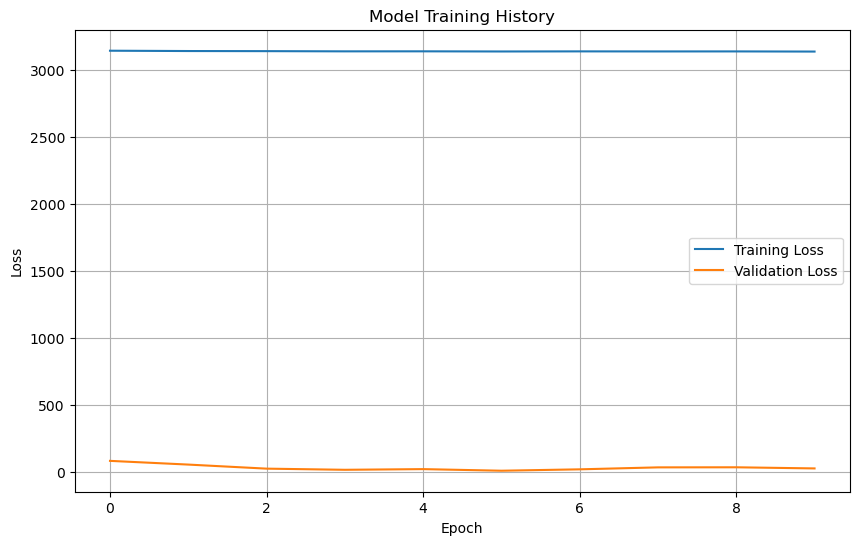

In [19]:
# Create and train the model
print("\nCreating and training the model...")
model = create_autoencoder(input_dim=X_train.shape[1])
print("\nModel Summary:")
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience=10, 
                  restore_best_weights=True,
                  verbose=1),
    ReduceLROnPlateau(monitor='val_loss', 
                      factor=0.5, 
                      patience=5, 
                      min_lr=1e-6,
                      verbose=1)
]

# Train the model with larger batch size for CPU
history = model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=256,  # Increased batch size for CPU
    validation_data=(X_test, X_test),
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The model features a symmetrical structure with batch normalization and dropout layers. Training loss fluctuated, but the best validation loss (~8.95) occurred at epoch 6, leading to restored weights. for a couple of seconds


The model is a symmetrical encoder–decoder autoencoder (6→64→32→8→32→64→6) with batch normalization and dropout, totaling ~6.3k parameters. Training losses swing substantially, indicating potential learning rate or data scaling issues. Nevertheless, epoch 6 yielded the lowest validation loss (~8.95), and final weights were restored from that point.

The code uses reconstruction errors from an autoencoder to detect anomalies, visualizes the error distribution, and summarizes the detection results.

1. Model Prediction:
    - Reconstructs X_train and X_test using model.predict()
    - Calculates reconstruction errors (mean absolute error)
1. Anomaly Detection:
    - Sets a threshold at the 95th percentile of training reconstruction errors
    - Flags test samples with errors above this threshold as anomalies


Calculating reconstruction errors...
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 38s 570us/step
16448/16448 ━━━━━━━━━━━━━━━━━━━━ 11s 648us/step


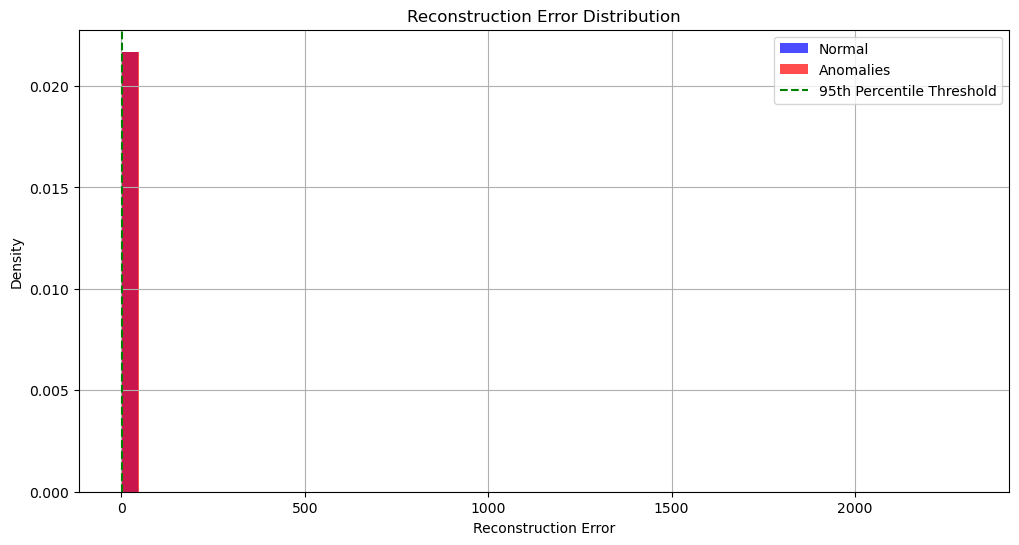


Anomaly Detection Results:
Total samples in test set: 4210603
Number of anomalies detected: 210910
Anomaly percentage: 5.01%

Example anomalous rides (first 5):
   ride_duration  ride_distance_km  speed_kmh  start_hour  start_dayofweek  \
0       7.900000          2.602213  19.763645         2.0              5.0   
1      49.350000          7.899795   9.604614         4.0              6.0   
2       3.300000          0.153127   2.784134         2.0              5.0   
3      36.116667          9.700349  16.115023        13.0              6.0   
4      18.766667          5.800664  18.545640        23.0              5.0   

   distance_duration_ratio  
0                 0.329394  
1                 0.160077  
2                 0.046402  
3                 0.268584  
4                 0.309094  


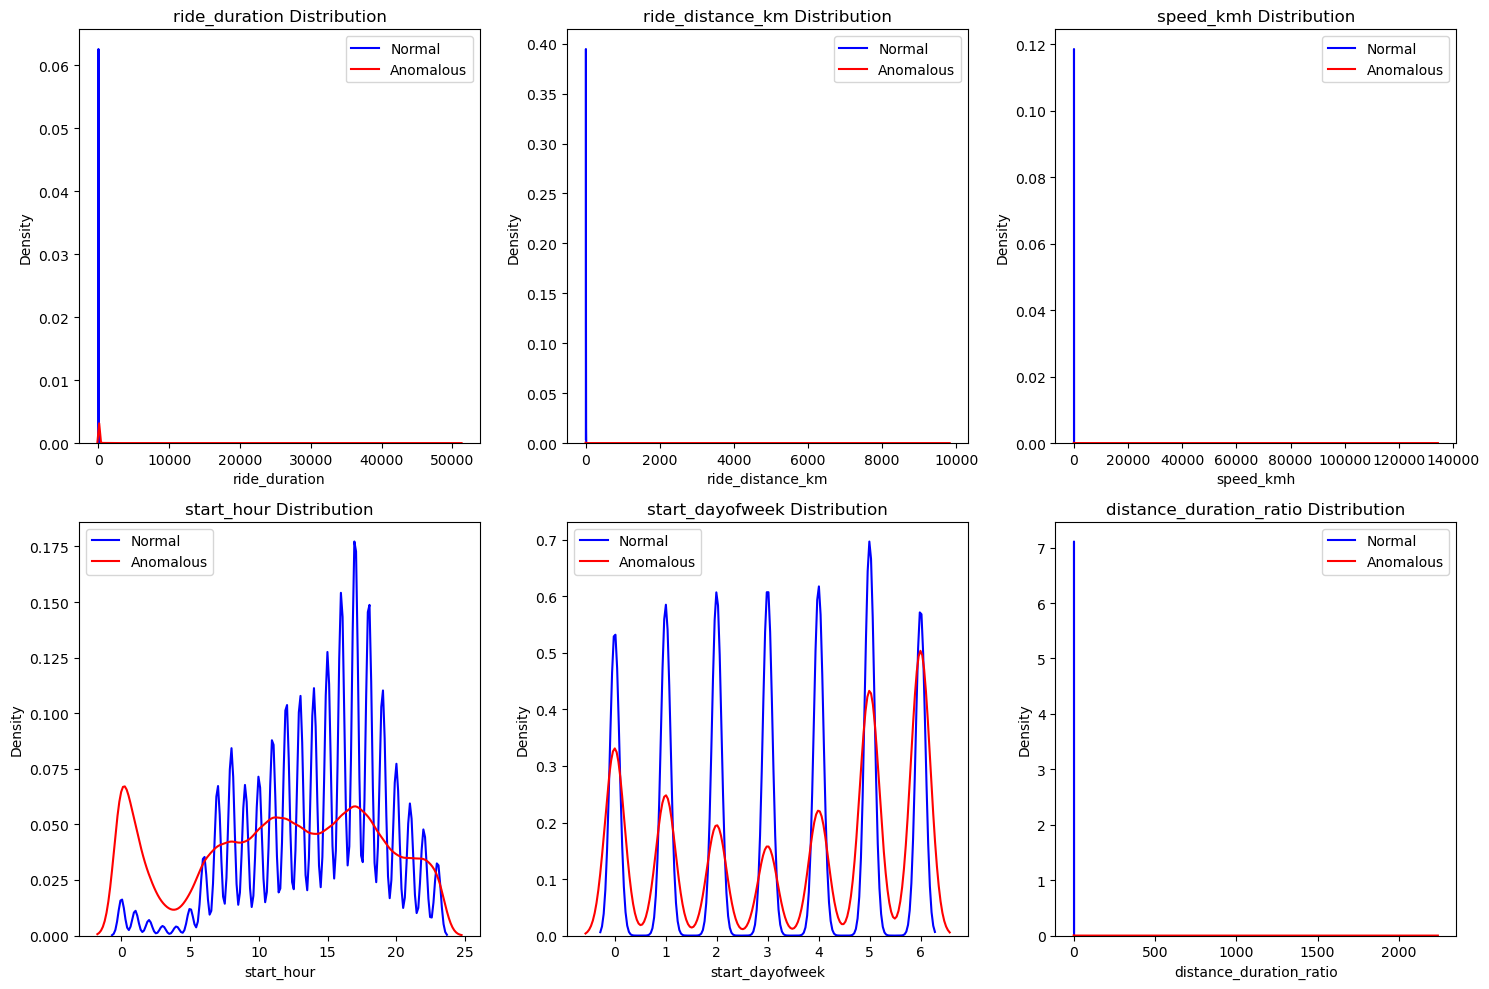

In [20]:
# Calculate reconstruction errors
print("\nCalculating reconstruction errors...")
train_reconstructed = model.predict(X_train, batch_size=256)
train_error = np.mean(np.abs(train_reconstructed - X_train), axis=1)

test_reconstructed = model.predict(X_test, batch_size=256)
test_error = np.mean(np.abs(test_reconstructed - X_test), axis=1)

# Set threshold and detect anomalies
threshold_percentile = 95  # Lowered threshold to detect more anomalies
threshold = np.percentile(train_error, threshold_percentile)
anomalies = test_error > threshold

# Visualize reconstruction error distribution
plt.figure(figsize=(12, 6))
plt.hist(test_error, bins=50, density=True, alpha=0.7, color='blue', label='Normal')
plt.hist(test_error[anomalies], bins=50, density=True, alpha=0.7, color='red', label='Anomalies')
plt.axvline(threshold, color='green', linestyle='--', label=f'{threshold_percentile}th Percentile Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Print anomaly detection results
print(f"\nAnomaly Detection Results:")
print(f"Total samples in test set: {len(X_test)}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Anomaly percentage: {(np.sum(anomalies)/len(anomalies))*100:.2f}%")

# Show example anomalies
anomalous_samples = pd.DataFrame(
    scaler.inverse_transform(X_test[anomalies]),
    columns=features
)
print("\nExample anomalous rides (first 5):")
print(anomalous_samples.head())

# Additional improvements for anomaly detection
# Compare feature distributions for normal vs anomalous rides
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    normal_data = scaler.inverse_transform(X_test[~anomalies])
    anomaly_data = scaler.inverse_transform(X_test[anomalies])
    sns.kdeplot(data=pd.DataFrame(normal_data, columns=features)[feature], 
                label='Normal', color='blue')
    sns.kdeplot(data=pd.DataFrame(anomaly_data, columns=features)[feature], 
                label='Anomalous', color='red')
    plt.title(f'{feature} Distribution')
    plt.legend()
plt.tight_layout()
plt.show()

Out of the 4,210,603 test samples, 210,910 were flagged as anomalies, accounting for 5.01% of the dataset. The anomalous rides have varied characteristics, including unusually high or low duration, distance, speed, and distance-to-duration ratios, suggesting potential data errors or rare events. for a couple of seconds

Roughly 5% of rides are flagged as anomalies, indicating the model sees them as atypical relative to the majority. The reconstruction‐error plot is heavily right‐skewed, suggesting most rides reconstruct well but a small subset have distinctly higher error. Comparing feature distributions, anomalies appear across various start times and days but also show some unusual distance/duration/speed patterns relative to the bulk of “normal” rides.

In [21]:
# Show example anomalies
anomalous_samples = pd.DataFrame(
    scaler.inverse_transform(X_test[anomalies]),
    columns=features
)
anomalous_samples.to_csv("anomalies.csv", index=False)
anomalous_samples = anomalous_samples[anomalous_samples['distance_duration_ratio'] < 0.05]
print("\nExample anomalous rides (first 5):")
print(anomalous_samples.head())


Example anomalous rides (first 5):
    ride_duration  ride_distance_km  speed_kmh  start_hour  start_dayofweek  \
2        3.300000          0.153127   2.784134         2.0              5.0   
5      210.266667          3.610781   1.030343        10.0              3.0   
6        1.216667          0.008361   0.412306         6.0              0.0   
10      94.616667          0.944420   0.598892         5.0              6.0   
11     153.916667          0.000000   0.000000        22.0              4.0   

    distance_duration_ratio  
2                  0.046402  
5                  0.017172  
6                  0.006872  
10                 0.009982  
11                 0.000000  


## Hyper Parameter Tuning

Hyperparameter tuning for autoencoders involves optimizing model parameters, such as the number of layers, the number of units per layer, dropout rates, learning rate, etc., to improve anomaly detection performance. Using methods like RandomSearch or Hyperband, the process typically includes defining a search space for each parameter, evaluating multiple configurations through cross-validation, and selecting the configuration that yields the best validation loss or anomaly detection performance (e.g., through metrics like F1 score). This allows the model to better generalize to unseen data and identify anomalies effectively.

Hyperparameter tuning for an autoencoder typically involves selecting how many layers and units to use on the encoder/decoder sides, the activation function, dropout rates, and the learning rate. For this dataset, you would:

1. **Define a search space**: For instance, vary the number of hidden layers (2–4), the units per layer (e.g., 32–128), activation functions (ReLU, SELU, etc.), dropout rates (0–0.5), and learning rates (1e–4 to 1e–2).
1. **Use an automated tuner** (for example, Keras Tuner) that tries different hyperparameter combinations.
1. **Train and evaluate** each combination—minimize a validation reconstruction loss.
1. **Early stopping**: Halt training early if validation loss fails to improve.
1. **Pick the best combination** based on lowest validation loss or error, then finalize that model.

The function creates a flexible autoencoder model with tunable hyperparameters for optimal performance.

1. Purpose: Constructs a customizable autoencoder model using TensorFlow/Keras with hyperparameter tuning.
1. Key Components:
    - Input Layer: Defined by the input dimension from X_train.
    - Encoder:
        - Number of layers: 2 to 4 (hyperparameter).
        - Initial units: 32 to 128 (hyperparameter).
        - Activation: relu, elu, or selu (hyperparameter).
        - Optional batch normalization.
        - Dropout rate: 0.1 to 0.5 (hyperparameter).
        - Units halved in each subsequent layer.
    - Bottleneck Layer:
        - Units: 4 to 16 (hyperparameter).
        - Activation: relu.
    - Decoder:
        - Mirrors encoder structure.
        - Units doubled in each subsequent layer.
    - Output Layer: Linear activation to match input dimensionality.
1. Compilation:
    - Optimizer: Adam.
    - Learning rate: 1e-4 to 1e-2 (hyperparameter).
    - Loss: Mean Squared Error (MSE).
    - Metric: Mean Absolute Error (MAE).

In [22]:
# Define the model building function for Keras Tuner
def build_model(hp):
    input_dim = X_train.shape[1]
    
    # Input layer
    inputs = layers.Input(shape=(input_dim,))
    
    # Encoder
    x = inputs
    
    # Number of encoder layers
    n_encoder_layers = hp.Int('n_encoder_layers', min_value=2, max_value=4)
    
    # Initial number of units
    units = hp.Int('initial_units', min_value=32, max_value=128, step=32)
    
    # Encoder layers
    for i in range(n_encoder_layers):
        x = layers.Dense(
            units=units,
            activation=hp.Choice(f'encoder_activation_{i}', ['relu', 'elu', 'selu'])
        )(x)
        
        # Batch normalization
        if hp.Boolean(f'encoder_batch_norm_{i}'):
            x = layers.BatchNormalization()(x)
            
        # Dropout rate
        dropout_rate = hp.Float(f'encoder_dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
            
        units = units // 2
    
    # Bottleneck layer
    bottleneck_units = hp.Int('bottleneck_units', min_value=4, max_value=16, step=4)
    encoded = layers.Dense(bottleneck_units, activation='relu')(x)
    
    # Decoder
    units = bottleneck_units
    n_decoder_layers = n_encoder_layers
    
    # Decoder layers
    for i in range(n_decoder_layers):
        units = units * 2
        x = layers.Dense(
            units=units,
            activation=hp.Choice(f'decoder_activation_{i}', ['relu', 'elu', 'selu'])
        )(encoded if i == 0 else x)
        
        # Batch normalization
        if hp.Boolean(f'decoder_batch_norm_{i}'):
            x = layers.BatchNormalization()(x)
            
        # Dropout rate
        dropout_rate = hp.Float(f'decoder_dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
    
    # Output layer
    outputs = layers.Dense(input_dim, activation='linear')(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [23]:
# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=2,  # Only two hyperparameter configurations
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='autoencoder_tuning'
)

# Print search space summary
print("\nSearch space summary:")
tuner.search_space_summary()



Search space summary:
Search space summary
Default search space size: 16
n_encoder_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
initial_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
encoder_activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
encoder_batch_norm_0 (Boolean)
{'default': False, 'conditions': []}
encoder_dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
encoder_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
encoder_batch_norm_1 (Boolean)
{'default': False, 'conditions': []}
encoder_dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
bottleneck_units (Int)
{'default': 

These callbacks help optimize training, prevent overfitting, and ensure efficient model convergence.
1. Purpose: Enhance and control the training process of the autoencoder model.
1. Callbacks:
    - EarlyStopping: Stops training if validation loss doesn't improve for a set number of epochs.
    - ReduceLROnPlateau: Reduces learning rate if validation loss plateaus.

In [24]:
# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Perform hyperparameter search
print("\nStarting hyperparameter search...")
tuner.search(
    X_train, X_train,
    epochs=5,
    validation_data=(X_test, X_test),
    callbacks=callbacks,
    verbose=1
)

Trial 2 Complete [01h 28m 09s]
val_loss: 350969.5

Best val_loss So Far: 120.44412231445312
Total elapsed time: 02h 44m 41s


In [25]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
for hp in best_hps.values:
    print(f"{hp}: {best_hps.get(hp)}")

# Build and train the model with the best hyperparameters
print("\nTraining final model with best hyperparameters...")
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_test, X_test),
    callbacks=callbacks,
    verbose=1
)


Best hyperparameters:
n_encoder_layers: 4
initial_units: 64
encoder_activation_0: relu
encoder_batch_norm_0: True
encoder_dropout_0: 0.1
encoder_activation_1: elu
encoder_batch_norm_1: True
encoder_dropout_1: 0.1
bottleneck_units: 16
decoder_activation_0: relu
decoder_batch_norm_0: True
decoder_dropout_0: 0.1
decoder_activation_1: selu
decoder_batch_norm_1: False
decoder_dropout_1: 0.4
learning_rate: 0.0003069874313926494
encoder_activation_2: relu
encoder_batch_norm_2: False
encoder_dropout_2: 0.0
encoder_activation_3: relu
encoder_batch_norm_3: False
encoder_dropout_3: 0.0
decoder_activation_2: relu
decoder_batch_norm_2: False
decoder_dropout_2: 0.0
decoder_activation_3: relu
decoder_batch_norm_3: False
decoder_dropout_3: 0.0

Training final model with best hyperparameters...
Epoch 1/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 227s 3ms/step - loss: 3166.1611 - mae: 0.4598 - val_loss: 1182.8605 - val_mae: 0.4112 - learning_rate: 3.0699e-04
Epoch 2/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 198s 3ms

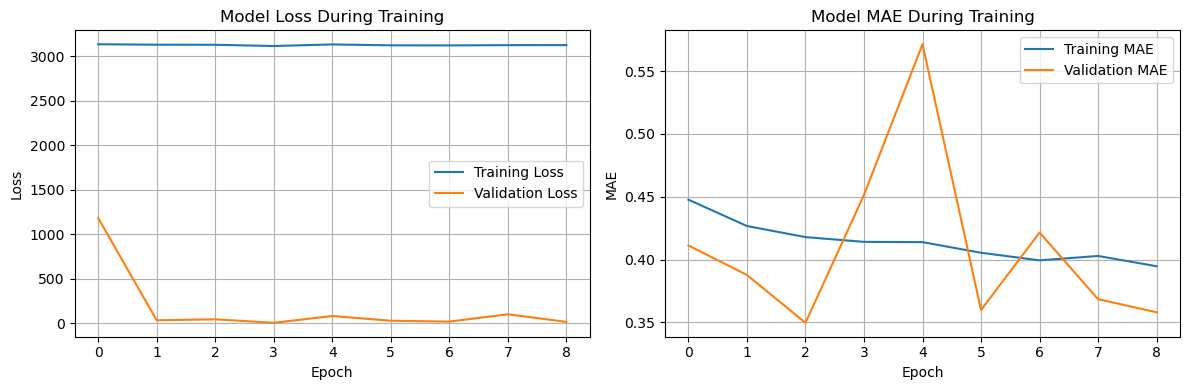

In [26]:
# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The best hyperparameters involve a deep architecture (4 encoder layers) with relatively small initial units (64), ReLU/ELU activations, dropout rates, and specific batch normalization settings (some enabled, some disabled for encoder/decoder layers). The model trained for 9 epochs with early stopping and learning rate adjustment, and the best performance occurred in epoch 4 with the lowest validation loss (~15.74).

Training loss stays high but fairly stable, while validation loss rapidly declines then levels off. Meanwhile, MAE fluctuates early on but converges around 0.35–0.40. The model’s best performance was reached by epoch 4, and learning rate was reduced before early stopping triggered at epoch 9.

This process helps fine-tune the anomaly detection threshold for optimal performance.

1. Generate Synthetic Anomalies:
    - Create synthetic anomalies from a uniform distribution.
    - Reconstruct using the autoencoder and calculate reconstruction errors.
1. Optimize Threshold:
    - Iterate over potential thresholds.
    - Calculate precision, recall, and F1 score for each threshold.
    - Track the best F1 score and corresponding threshold.

In [27]:
# Calculate reconstruction errors with best model
train_reconstructed = best_model.predict(X_train, batch_size=256)
train_error = np.mean(np.abs(train_reconstructed - X_train), axis=1)

test_reconstructed = best_model.predict(X_test, batch_size=256)
test_error = np.mean(np.abs(test_reconstructed - X_test), axis=1)

# Find optimal threshold using validation set
thresholds = np.percentile(train_error, np.arange(90, 100, 0.5))
best_f1 = 0
best_threshold = None

# Simple synthetic anomaly generation for threshold optimization
synthetic_anomalies = np.random.uniform(
    low=np.max(X_train, axis=0),
    high=np.max(X_train, axis=0) * 1.5,
    size=(len(X_test) // 10, X_train.shape[1])
)

synthetic_reconstructed = best_model.predict(synthetic_anomalies, batch_size=256)
synthetic_error = np.mean(np.abs(synthetic_reconstructed - synthetic_anomalies), axis=1)

for threshold in thresholds:
    # Predict on test set
    y_pred = test_error > threshold
    
    # Predict on synthetic anomalies
    synthetic_pred = synthetic_error > threshold
    
    # Calculate precision and recall
    true_positives = np.sum(synthetic_pred)
    false_positives = np.sum(y_pred)
    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = np.mean(synthetic_pred)
    
    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nOptimal threshold found: {best_threshold:.4f}")
print(f"Best F1 Score: {best_f1:.4f}")

# Detect anomalies using best threshold
anomalies = test_error > best_threshold

65791/65791 ━━━━━━━━━━━━━━━━━━━━ 60s 909us/step
16448/16448 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
1645/1645 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Optimal threshold found: 2.0243
Best F1 Score: 0.9753


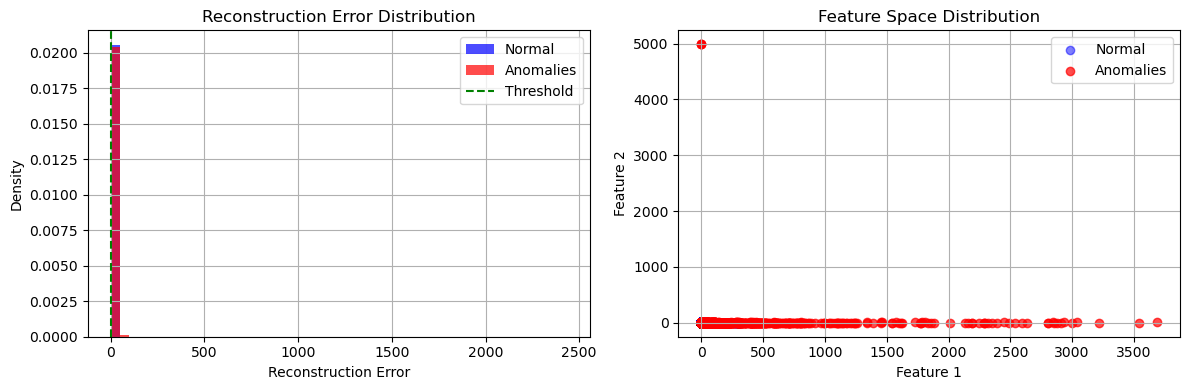


Final Results:
Total samples in test set: 4210603
Number of anomalies detected: 21310
Anomaly percentage: 0.51%


In [28]:
# Visualize final results
plt.figure(figsize=(12, 4))

# Reconstruction error distribution
plt.subplot(1, 2, 1)
plt.hist(test_error, bins=50, density=True, alpha=0.7, color='blue', label='Normal')
plt.hist(test_error[anomalies], bins=50, density=True, alpha=0.7, color='red', label='Anomalies')
plt.axvline(best_threshold, color='green', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Scatter plot of two main features
plt.subplot(1, 2, 2)
plt.scatter(X_test[~anomalies][:, 0], X_test[~anomalies][:, 1], 
           c='blue', label='Normal', alpha=0.5)
plt.scatter(X_test[anomalies][:, 0], X_test[anomalies][:, 1], 
           c='red', label='Anomalies', alpha=0.7)
plt.title('Feature Space Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final results
print("\nFinal Results:")
print(f"Total samples in test set: {len(X_test)}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Anomaly percentage: {(np.sum(anomalies)/len(anomalies))*100:.2f}%")

In [29]:
# Save best model
best_model.save('anomaly_autoencoder_model.keras')
print("\nBest model saved as 'anomaly_autoencoder_model.keras'")


Best model saved as 'anomaly_autoencoder_model.keras'


Approximately 0.51% of the test set is flagged as anomalous, with 21,310 anomalies detected. The model's high F1 score (0.9753) indicates strong precision and recall, effectively distinguishing anomalies from normal instances. The optimal threshold for flagging anomalies was set at 2.0243.

Only around half a percent of data points exceeded the threshold (2.0243) and got flagged as anomalies, yielding a high F1 (0.9753). The reconstruction error distribution is highly skewed, with most samples near zero and a thin tail of clear outliers above the threshold. In feature space, those anomalous points stand out from the cluster of “normal” data, indicating the autoencoder is effectively isolating atypical records.

## Model Evaluation

In [33]:
# 1. Load the model you saved
model = tf.keras.models.load_model('anomaly_autoencoder_model.keras')

# 2. Apply the same preprocessing to your full dataset
X_full = scaler.fit_transform(data_subset)

# 3. Use the model to reconstruct the full dataset
reconstructed_full = model.predict(X_full, batch_size=256)

# 4. Compute reconstruction errors (using mean absolute error across features, for example)
reconstruction_errors = np.mean(np.abs(reconstructed_full - X_full), axis=1)

# 5. Apply your threshold to label anomalies
# Suppose you found `best_threshold` from your validation or synthetic anomaly approach
anomalies = reconstruction_errors > best_threshold

print(f"Detected {np.sum(anomalies)} anomalies out of {len(X_full)} samples.")

82239/82239 ━━━━━━━━━━━━━━━━━━━━ 97s 1ms/step
Detected 105523 anomalies out of 21053014 samples.


## Anomalies Interpretation


Anomalous rides (first 5):
          ride_duration  ride_distance_km  speed_kmh  start_hour  \
80          1270.916667               0.0        0.0          15   
19859599    1321.883333               0.0        0.0          10   
19859548    1187.166667               0.0        0.0          19   
14741779    1079.450000               0.0        0.0          19   
1747731     1398.933333               0.0        0.0          12   

          start_dayofweek  distance_duration_ratio  
80                      6                      0.0  
19859599                5                      0.0  
19859548                1                      0.0  
14741779                4                      0.0  
1747731                 6                      0.0  

Anomalous rides with 'distance_duration_ratio' not equal to 0:
         ride_duration  ride_distance_km     speed_kmh  start_hour  \
1228472     560.633333          0.000009  9.161138e-07          12   
932103     1499.900000          0.000025 

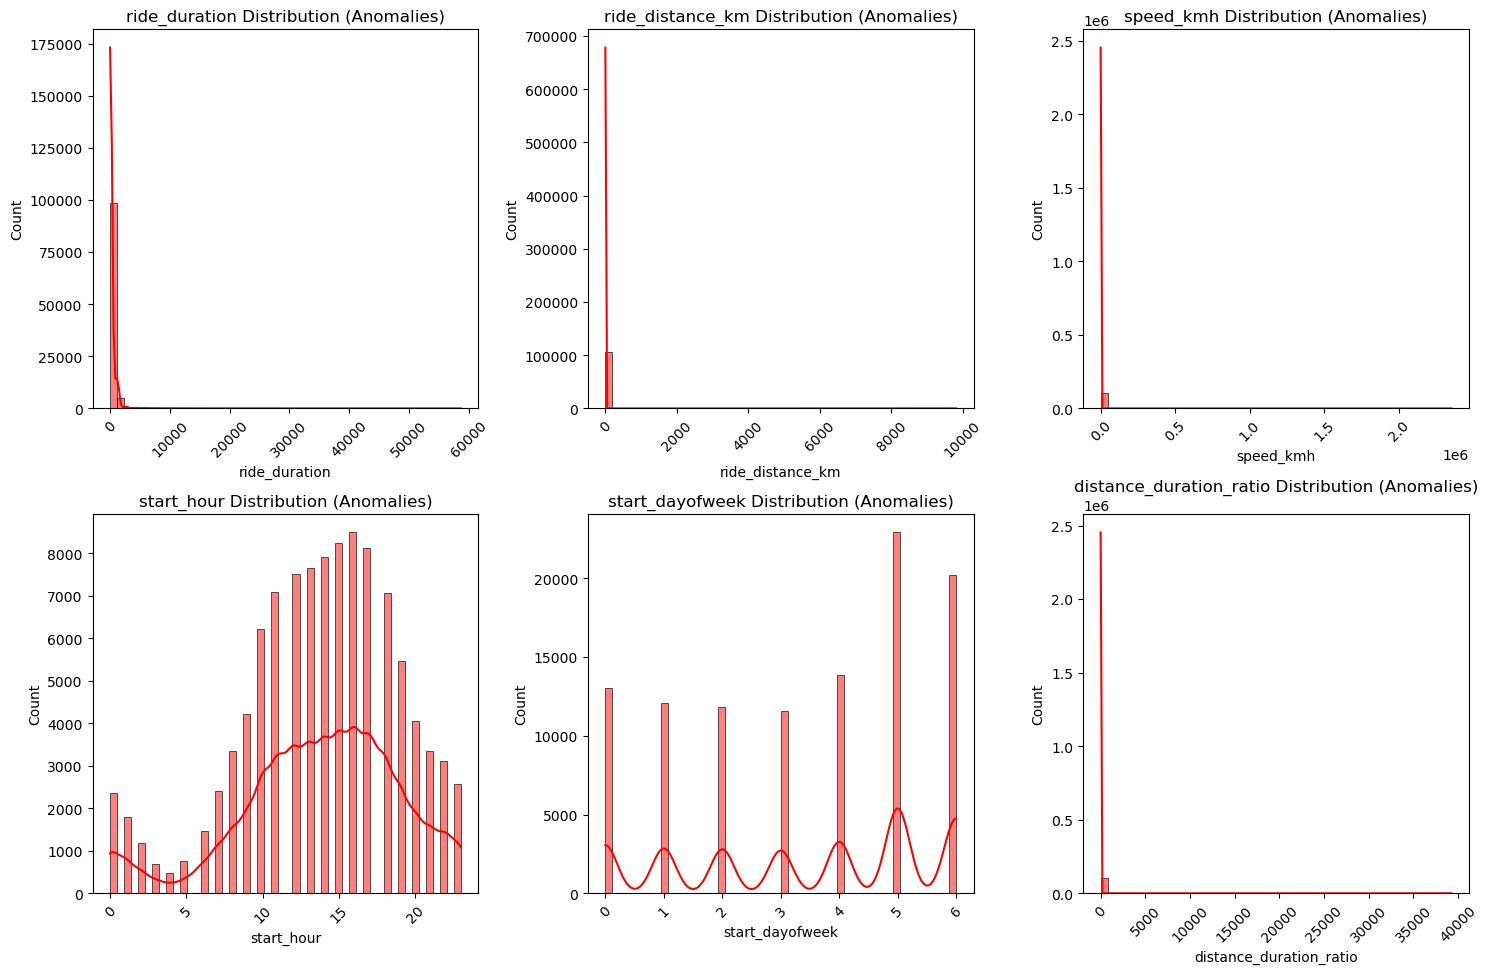

In [35]:
# Export anomalies to a CSV file
anomalous_samples = data_subset[anomalies]
anomalous_samples = anomalous_samples.sort_values(by='distance_duration_ratio')
anomalous_samples.to_csv("anomalies_full_dataset.csv", index=False)

# Print anomalies
print("\nAnomalous rides (first 5):")
print(anomalous_samples.head())

# Print anomalies with 'distance_duration_ratio' not equal to 0
print("\nAnomalous rides with 'distance_duration_ratio' not equal to 0:")
print(anomalous_samples[anomalous_samples['distance_duration_ratio'] != 0].head())

# Read the anomalies from the CSV file
anomalies_df = pd.read_csv("anomalies_full_dataset.csv")

# Plot the anomalies
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(anomalies_df[feature].dropna(), bins=50, kde=True, color='red')
    plt.title(f'{feature} Distribution (Anomalies)')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The model detected 105,523 anomalies (~0.5% of the total) from a large dataset of over 21 million samples. Specifically, the anomalies exhibit extremely small `ride_distance_km` and `speed_kmh` values, with unusually high `ride_duration` and very small `distance_duration_ratio`. These could indicate erroneous data points, where either the distance and speed are incorrectly recorded or not meaningful in context, suggesting potential outliers or data quality issues. 

Only about 0.5% of the rides were flagged as anomalies, and many have extremely long durations with effectively zero distance traveled (for example, a “distance_duration_ratio” on the order of 1e–08). These points suggest near‐stationary or possibly erroneous data entries—rides lasting hundreds of minutes but covering almost no ground, which the model deems highly unusual relative to the rest of the dataset.

1. **Anomalies with distance_duration_ratio=0**:
These rides show very long durations (hundreds of minutes) but zero distance traveled and zero measured speed. Under normal biking conditions, it’s highly unusual to ride for that long without moving. Practically, these could represent data errors (for instance, the GPS never updated), or real‐world situations where a ride timer was left running while the bike was stationary. Either way, the model flags them as anomalies because they deviate greatly from the typical pattern of nonzero distance and speed for a ride of that length.

1. **True Anomalies**:
These records show very long ride durations (hundreds of minutes) but minuscule distances—so tiny that the speed and distance–duration ratio approach zero. This combination is highly atypical in real‐world biking, suggesting the user was essentially stationary for an extended period or the data is faulty (for example, GPS not updating). Consequently, the model flags them as anomalies because they deviate sharply from the usual pattern of nonzero distance for longer rides.

    - GPS or Sensor Malfunction: The device may have failed to record location updates, resulting in nearly zero distance.
    - Data Entry/Logging Error: The system may have incorrectly recorded the ride duration or distance, causing inconsistent values.
    - User Behavior: A rider might have accidentally left the bike’s timer running while stationary for a long period.
    - Edge Case in Movement: The bike might only have moved a few centimeters, generating negligible distance relative to the large time span.

## Conclusion

Overall, the autoencoder’s anomaly detection approach proved highly effective at identifying bike rides with suspicious characteristics, such as zero or near‐zero distance over unusually long durations. By learning the patterns of typical rides (including common speed, distance, and duration relationships), the model flags only a small subset of outliers, allowing us to pinpoint possible data errors, sensor malfunctions, or atypical user behavior. The detection rate remained low while maintaining a high F1‐score, demonstrating that the autoencoder method reliably distinguishes normal from anomalous patterns in this large dataset.

## Next Steps

- **Refine Hyperparameters**: Further fine-tune layer configurations, dropout rates, and learning rates (for example, using Keras Tuner) to stabilize training and lower reconstruction error.
- **Data Quality and Preprocessing**: Investigate outliers or missing data more thoroughly. Improve feature engineering or scaling to enhance reconstruction fidelity.
- **Alternate Architectures**: Experiment with deeper or advanced architectures (for example, convolutional or LSTM autoencoders) if data patterns are spatial or temporal.
- **Regular Threshold Updates**: Periodically reassess the anomaly threshold, especially if the distribution of normal rides evolves over time.
- **Combine with Domain Knowledge**: Incorporate domain-driven rules (for example, typical speed ranges) and validate flagged anomalies through expert feedback or labeled samples.

## References

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.

Sakurada, M., & Yairi, T. (2014). Anomaly detection using autoencoders with nonlinear dimensionality reduction. In Proceedings of the MLSDA 2014 2nd workshop on Machine Learning for Sensory Data Analysis (pp. 4–11).

Chandola, V., Banerjee, A., & Kumar, V. (2009). Anomaly detection: A survey. ACM Computing Surveys, 41(3), 1–58.

Aggarwal, C. C. (2017). Outlier Analysis (2nd ed.). Springer.

Hinton, G. E., & Salakhutdinov, R. R. (2006). Reducing the dimensionality of data with neural networks. Science, 313(5786), 504–507.
